#Import Packages

In [ ]:
#import necessary packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import joblib

#Data Analysis and Pre-processing


When given a regression task on a new dataset, the first thing I would do is to study the dataset and its attributes, to better understand them and their correlation with the proposed target attribute, in this case "gross_tonnage".
I will define the path of my working directory, then read the input data file in a Pandas Dataframe and print some rows to analyze it.

In [ ]:
#define the path for working directory, read the csv file in a pandas dataframe and print it, to see some examples records

path = "" #to be changed with your working directory
file_name = "ship_data.csv"

dataset = pd.read_csv(path + file_name)
dataset

,Ship_name,Cruise_line,Age,cabins,crew,passengers,length,passenger_density,gross_tonnage
0,Journey,Azamara,6,3.55,3.55,6.94,5.94,42.64,30.277
1,Quest,Azamara,6,3.55,3.55,6.94,5.94,42.64,30.277
2,Celebration,Carnival,26,7.43,6.70,14.86,7.22,31.80,47.262
3,Conquest,Carnival,11,14.88,19.10,29.74,9.53,36.99,110.000
4,Destiny,Carnival,17,13.21,10.00,26.42,8.92,38.36,101.353
...,...,...,...,...,...,...,...,...,...
153,Taurus,Star,22,0.33,0.59,0.66,2.79,50.62,3.341
154,Virgo,Star,14,9.67,12.00,19.60,8.79,39.18,76.800
155,Spirit,Windstar,25,0.74,0.88,1.58,4.40,33.86,5.350
156,Star,Windstar,27,0.74,0.88,1.67,4.40,32.04,5.350


Analyzing the attributes, firstly I want to understand what the target attribute means, since I am not acquainted with ship characteristics. *Gross tonnage is a nonlinear measure of a ship's overall internal volume.[...] calculated based on "the moulded volume of all enclosed spaces of the ship"* ([Wikipedia](https://en.wikipedia.org/wiki/Gross_tonnage)).
It is now clear that attributes like *Ship_name* or *Cruise_line* have little to nothing to do with the target and can be easily filtered out, while *length* is a key attribute for the regression. Anyway, since the actual Volume of the ship is not directly derivable from the data, I can't easily compute the gross tonnage of the ships. For this reason, it is convenient to check if any other attribute has a strong correlation with the target.

In [ ]:
#remove duplicates and check missing values

dataset = dataset.drop_duplicates(subset=['Ship_name', 'Cruise_line'])
dataset.count()

Ship_name            158
Cruise_line          158
Age                  158
cabins               158
crew                 158
passengers           158
length               158
passenger_density    158
gross_tonnage        158
dtype: int64

Before dropping said attributes, just to be sure, I tried to remove duplicates, since I assume there isn't any ship with the same name in the same Cruise line. Also, I checked for missing values, but comparing the number of records and n. of values per attribute, I acknowledge that there wasn't any duplicate nor missing value.

[Text(0.5, 1.0, 'Correlation Heatmap')]

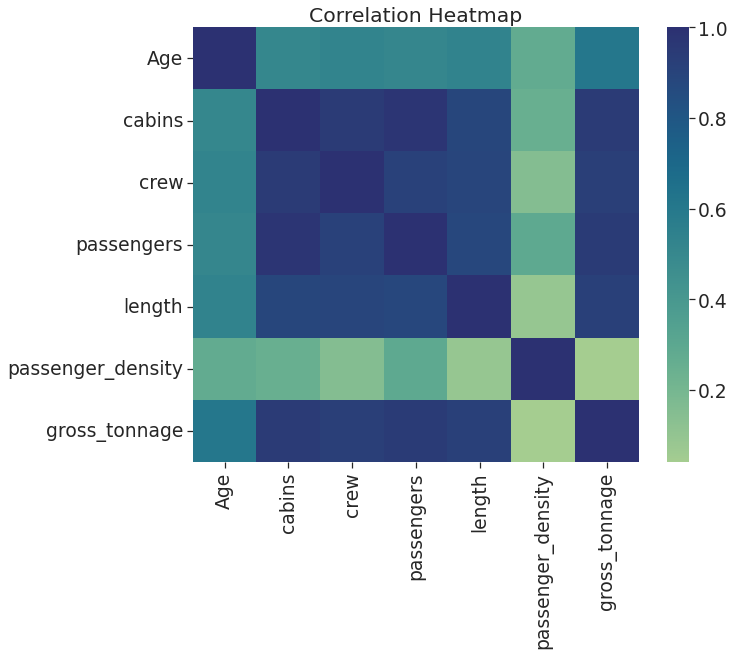

In [ ]:
#drop non-numeric attributes and build an heatmap showing attributes correlation

dataset = dataset.drop(columns=['Ship_name', 'Cruise_line'])

sns.set(font_scale=1.7)
sns.set_style("ticks")
plot, ax = plt.subplots(1,1, figsize=(10,8))
plot = sns.heatmap(abs(dataset.corr()),cmap="crest")
plot.set(title="Correlation Heatmap")

From the heatmap it is clear that the *passenger_density* has a really low correlation with the target attribute, so I will drop it. For what concerns the *Age* attribute, even if the correlation is not too low, i would say that it has nothing to do with the target, so i will filter it out, since this correlation could be a bias in the dataset and could cause problems with the generalization of the regressor. Also, one attribute between *cabins* and *passengers* has to be left out, since there is a high correlation between them.

In [ ]:
#drop "Age", "passenger_density" and "cabins" attributes

dataset = dataset.drop(columns=['Age', 'passenger_density', 'cabins'])
dataset

,crew,passengers,length,gross_tonnage
0,3.55,6.94,5.94,30.277
1,3.55,6.94,5.94,30.277
2,6.70,14.86,7.22,47.262
3,19.10,29.74,9.53,110.000
4,10.00,26.42,8.92,101.353
...,...,...,...,...
153,0.59,0.66,2.79,3.341
154,12.00,19.60,8.79,76.800
155,0.88,1.58,4.40,5.350
156,0.88,1.67,4.40,5.350


Then, since the dataset is very small, it is important to remove outliers, to avoid overfitting. I will do it using a scikit-learn outlier detector, the Isolation Forest, and then a mask to avoid using them in the training process.

In [ ]:
#marking and removing outliers from data

detector = IsolationForest(contamination=0.1)
outliers = detector.fit_predict(dataset)
mask = outliers != -1
dataset = dataset[mask]

print("From the " + str(len(mask)) + " records in the dataset, " + str(len(mask) - len(dataset)) + " records have been marked as outliers and removed.\n\n")

From the 158 records in the dataset, 15 records have been marked as outliers and removed.




/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


Finally, since working with non-scaled data will potentially force the algorithm to iterate more, I'm checking the distributions of the chosen attributes and comparing them to the ones scaled with sklearn Standard Scaler.

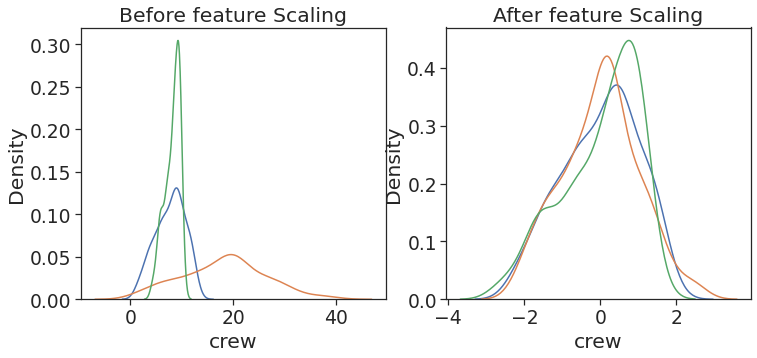

In [ ]:
#create two graphs, showing the attributes' distributions before and after the scaling process

df = dataset
df = df.drop(columns=['gross_tonnage']) #drop the target since I'm not interested in scaling it
    
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['crew', 'passengers', 'length'])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.set_title('Before feature Scaling')
sns.kdeplot(df['crew'], ax=ax1)
sns.kdeplot(df['passengers'], ax=ax1)
sns.kdeplot(df['length'], ax=ax1)
ax2.set_title('After feature Scaling')
sns.kdeplot(scaled_df['crew'], ax=ax2)
sns.kdeplot(scaled_df['passengers'], ax=ax2)
sns.kdeplot(scaled_df['length'], ax=ax2)
plt.show()

As the difference between the ranges of values is visible, it is a good idea to scale the dataset.
Then I separate the target from the data and split in train and test sets.

In [ ]:
#separate the target from the data and split using sklearn train_test_split

target_name = "gross_tonnage"
target = dataset[target_name]
data = scaled_df #i had already dropped the target attribute before scaling

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=42)

#Model Definition

Due to the low number of records and attributes in the training data, which can easily cause overfitting, I have decided to use the Random Forest regressor, since it's composed by many decision trees and makes a prediction by majority voting. This can reduce overfitting and improve performances.

##Hyperparameters Tuning

To find the best hyperparameters, a Grid Search minimizing the Mean Squared Error is used, with 5-folds cross validation to improve generalization. I have included in the parameters grid only the hyperparameters and values I find relevant to the task.
After the search is complete, I will use the best model found by it to get predictions of the test set, to then print some relevant metrics.

In [ ]:
#define the parameters to be tested
param_grid = {
"n_estimators": [25, 50, 75, 100, 150],
"max_depth": [2, 3], #i will keep the max depth parameter low since the dataset is small, to avoid unnecessary complexity
"max_features": ["auto", "sqrt", 0.33],
"min_samples_leaf": [1, 2],
"min_samples_split": [2, 4]
}

#create the grid and fit it, to then get predictions and print metrics
model = GridSearchCV(RandomForestRegressor(), param_grid, scoring="neg_mean_squared_error", cv=5)
model.fit(data_train, target_train)
res = model.predict(data_test)

print(model.best_params_)
print("r2 score: " + str(metrics.r2_score(target_test, res)))
print("MSE: " + str(metrics.mean_squared_error(target_test, res)))
print("MAE: " + str(metrics.mean_absolute_error(target_test, res)))

{'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
r2 score: 0.9518055306693046
MSE: 53.06849170043371
MAE: 5.89836094840765


By examining the best parameters' set in different runs with different random states in the dataset split, I've come to the conclusion that the *max_features* parameter is irrelevant to the task so i will keep the default *'auto'* setting. Also the *min_samples_split* parameter seems irrelevant, since we force the *max_depth* to 3, but it will be set to 4 anyway, to avoid too much specificity. For what concerns the number of estimators, the best results have been obtained between 50 and 100 trees, so i will use 75. Lastly, *min_samples_leaf* will be set to 1.

##Training and Saving the Final Model

Now I can define the model with the right hyperparameters and train it with the full dataset, to improve performances.

In [ ]:
#define the model
final_model = RandomForestRegressor(n_estimators=75, max_depth=3, max_features='auto', min_samples_leaf=1, min_samples_split=4)

#train the model on the full dataset
final_model.fit(data, target)

RandomForestRegressor(max_depth=3, min_samples_split=4, n_estimators=75)

After training, I will save the model to file for future use.

In [ ]:
#save the model to file
model_name = "gross_tonnage_predictor" #can be changed

joblib.dump(final_model, path + model_name + ".joblib")

['/content/drive/MyDrive/Colab Notebooks/DuckDuckGoose/gross_tonnage_predictor.joblib']

#Usage Example

To use the model and obtain predictions, the input data should be one or more records containing 3 values, each one for *crew*, *passengers* and *length* attributes respectively. In this example I will use a record from the *test set*, even if it's data already used in training.

In [ ]:
#taking a sample record

sample_input = data_test.sample() #to be changed with your input
sample_input

,crew,passengers,length
117,1.40969,1.618556,1.375852


To get predictions, simply load the model using *joblib* package and call its *predict* method, using as input the data prepared before. Then, print or use the prediction as needed.

In [ ]:
#load the model
model_path = path + model_name + ".joblib" #to be changed with your saved model path

predictor = joblib.load(model_path)

In [ ]:
#get prediction(s)

prediction = predictor.predict(sample_input)

print(f"The predicted value for gross tonnage is {prediction[0]}")

The predicted value for gross tonnage is 133.38607739694575
